In [1]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
import pickle

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
basedir = "G:\\My Drive\\Figures\\TwoTower\\SingleSession\\"

In [3]:
df = pp.load_session_db()


df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_foraging'
df = df[df['Track'].str.contains(tracks,regex=True)]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222168.1\09_08_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222169.2\26_08_2019\TwoTower_Timeout_0.sqlite
file doesn't exist, errors to come!!!


In [4]:
def PC_list_maker(mlist,firstSess = None):
    
    FR_dict = {}
    
    FR_dict[0],FR_dict[1]={},{}
    if firstSess is None:
        firstSess = len(mlist)*[5]
    elif isinstance(firstSess,int):
        firstSess = len(mlist)*[firstSess]
    else:
        pass
    
    
    for i, (mouse,f_ind) in enumerate(zip(mlist,firstSess)): 

        df_mouse = df[df['MouseName'].str.match(mouse)]
        for mat_ind,sess_ind in enumerate(np.arange(f_ind,df_mouse.shape[0]).tolist()):
            print("session ind",sess_ind)
            
            sess = df_mouse.iloc[sess_ind]
            VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
            trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)

            S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=10,speed=VRDat['speed']._values)
            S_trial_mat[np.isnan(S_trial_mat)]=0
            
            
            
            S_morph_dict = u.trial_type_dict(S_trial_mat,trial_info['morphs'])
            
            S_mu,l = u.across_trial_avg(S_trial_mat,trial_info['morphs'])
            if i==0 and mat_ind==0:
                MU = S_mu
               
            else:
                MU = np.concatenate((MU,S_mu),axis=-1)
                
            
            pc_file = os.path.join(basedir,mouse,"%s_%s_%i" % (sess['Track'],sess['DateFolder'],sess['SessionNumber']),'pc_masks.pkl')
#             try:
#                 with open(pc_file,'rb') as f:
#                     masks = pickle.load(f)['masks']
#             except:
            masks, FR, SI = pc.place_cells_calc(S, VRDat['pos']._values,trial_info,
                    VRDat['tstart']._values, VRDat['teleport']._values,
                    method='bootstrap',correct_only=False,speed=VRDat.speed._values,
                    win_trial_perm=True,morphlist=[0,1])
            with open(pc_file,'wb') as f:
                pickle.dump({'masks':masks},f)
                
            fr_dict = pc.plot_placecells(S_morph_dict,masks,plot=False)
            
           
            for sort in [0,1]:
                for m in [0,.25,.5,.75,1.]:
                    if i==0 and mat_ind == 0:
                        
                        FR_dict[sort][m] = fr_dict[sort][m]
                    else:
                        FR_dict[sort][m]=np.concatenate((FR_dict[sort][m],fr_dict[sort][m]),axis=0)
    return FR_dict, MU
           
    

In [12]:
def PC_mask_counter(mlist,firstSess = None):
    
    FR_dict = {}
    
    FR_dict[0],FR_dict[1]={},{}
    if firstSess is None:
        firstSess = len(mlist)*[5]
    elif isinstance(firstSess,int):
        firstSess = len(mlist)*[firstSess]
    else:
        pass
    
    or_cellcount,and_cellcount = 0,0
    count0,count1 = 0,0
    N = 0
    Nlist=[]
    for i, (mouse,f_ind) in enumerate(zip(mlist,firstSess)): 

        df_mouse = df[df['MouseName'].str.match(mouse)]
        for mat_ind,sess_ind in enumerate(np.arange(f_ind,df_mouse.shape[0]).tolist()):
#             print("session ind",sess_ind)
            
            sess = df_mouse.iloc[sess_ind]
            
            pc_file = os.path.join(basedir,mouse,"%s_%s_%i" % (sess['Track'],sess['DateFolder'],sess['SessionNumber']),'pc_masks.pkl')
            try:
                with open(pc_file,'rb') as f:
                    masks = pickle.load(f)['masks']
            except:
                masks, FR, SI = pc.place_cells_calc(S, VRDat['pos']._values,trial_info,
                        VRDat['tstart']._values, VRDat['teleport']._values,
                        method='bootstrap',correct_only=False,speed=VRDat.speed._values,
                        win_trial_perm=True,morphlist=[0,1])
                with open(pc_file,'wb') as f:
                    pickle.dump({'masks':masks},f)
                    
            or_cellcount +=( masks[0] | masks[1]).sum() 
            and_cellcount += (masks[0] & masks[1]).sum()
#             print(masks[0])
            count0+=masks[0].sum()
            count1+=masks[1].sum()
            N+=masks[0].shape[0]
            Nlist.append(masks[0].shape[0])
    return or_cellcount/N,and_cellcount/N,count0/N,count1/N,N,Nlist
           

In [13]:
Rare_orcount, Rare_andcount,Rare_0,Rare_1,Rare_N,Rare_Nlist = PC_mask_counter(['4139265.5','4139265.4','4139265.3','4222168.1'],firstSess=[5,5,5,3])
Fam_orcount, Fam_andcount,Fam_0,Fam_1,Fam_N,Fam_Nlist = PC_mask_counter(['4222153.2','4222153.3','4222153.1','4222174.1','4222154.1'],firstSess=4)
print(Rare_orcount,Fam_orcount)
# print(Rare_andcount/Rare_orcount,Fam_andcount/Fam_orcount)
print('Rare')
print(Rare_0,Rare_1)
print(Rare_0*Rare_1,Rare_andcount)
print('excess',Rare_0*Rare_1-Rare_andcount)
print('Fam')
print(Fam_0,Fam_1)
print(Fam_1*Fam_0,Fam_andcount)
print('excess',Fam_1*Fam_0-Fam_andcount )



Nlist = np.array(Rare_Nlist+Fam_Nlist)
print(Nlist.max(),Nlist.min())
print(Nlist)

0.49227357527544086 0.34015986378470414
Rare
0.3041641733253546 0.3021225667922137
0.09189486077128792 0.11401316484212749
excess -0.022118304070839576
Fam
0.21269450882088634 0.17665421179586624
0.0375733808090626 0.04918885683204843
excess -0.011615476022985835
2149 98
[ 915  976  984  932 1047 1632 1656 1515 1650 1498 1631 1828 1904 1817
 1708 1715  886  919 1035 1074 1087 2127 2149 2046 1951  161   98  301
  273  237 1963 1998 2047 2117 1901  309  571  326  311  257]


In [14]:
# single permutation
def _perm(p0,p1,N):
    pop_0,pop_1 = np.random.rand(N)<=p0, np.random.rand(N)<=p1
    return (pop_0 & pop_1).sum()/N
    
def ovlp_permtest(p0,p1,pc,N,perms=1000):
    null_pc = []
    for p in range(perms):
        null_pc.append(_perm(p0,p1,N))
        
    return (null_pc>pc).sum()/perms

rare_p = ovlp_permtest(Rare_0,Rare_1,Rare_andcount,Rare_N)
print(rare_p)
fam_p = ovlp_permtest(Fam_0,Fam_1,Fam_andcount,Fam_N)
print(fam_p)
# make a population of size N

# generate 0-1 random numbers, take the ones below threshold
_rand = np.random.rand(Rare_N)
pop_0,pop_1 = np.random.rand(Rare_N)<=Rare_0, np.random.rand(Rare_N)<=Rare_1
_and = (pop_0 & pop_1).sum()/Rare_N
print(_and)



0.0
0.0
0.09123869196381429


In [6]:
Rare_dict, Rare_mu = PC_list_maker(['4139265.5','4139265.4','4139265.3','4222168.1'],firstSess=[5,5,5,3])
Fam_dict, Fam_mu=PC_list_maker(['4222153.2','4222153.3','4222153.1','4222174.1','4222154.1'],firstSess=4)

session ind 5
num aberrant ttls 0.0
34737 (34737,) (34737, 21) 113863
(113863,) (113863, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 6
num aberrant ttls 0.0
36018 (36018,) (36018, 21) 118606
(118606,) (118606, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 7
num aberrant ttls 0.0
40272 (40272,) (40272, 21) 133982
(133982,) (133982, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 8
num aberrant ttls 0.0
36659 (36659,) (36659, 21) 120387
(120387,) (120387, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 9
num aberrant ttls 0.0
36583 (36583,) (36583, 21) 124384
(124384,) (124384, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 5
num aberrant ttls 0.0
30897 (30897,) (30897, 21) 102093
(102093,) (102093, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
sess

In [7]:
print(Rare_dict[0][0].shape,Rare_dict[0][1].shape)
print(Rare_dict[1][0].shape,Rare_dict[1][1].shape)

(8641, 45) (8641, 45)
(8583, 45) (8583, 45)


In [8]:
print(Fam_dict[0][0].shape,Fam_dict[0][1].shape)
print(Fam_dict[1][0].shape,Fam_dict[1][1].shape)

(4497, 45) (4497, 45)
(3735, 45) (3735, 45)


In [15]:
df = pp.load_session_db()

df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_noTimeout|TwoTower_Timeout|FreqMorph_Decision|FreqMorph_Timeout'
df = df[df['Track'].str.contains(tracks,regex=True)]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222168.1\09_08_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222169.2\26_08_2019\TwoTower_Timeout_0.sqlite
file doesn't exist, errors to come!!!


In [16]:
FD_dict, FD_mu = PC_list_maker(['4222157.4','4222169.1','4222169.4'],firstSess=[5,5,5])

session ind 5
num aberrant ttls 0.0
27977 (27977,) (27977, 21) 78367
(78367,) (78367, 21)
frame diff 0


C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:334: RuntimeWarning: Mean of empty slice
  zone1_speed[i] = np.nanmean(sub_frame.loc[zone1_mask,'speed'])
C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:333: RuntimeWarning: Mean of empty slice
  zone0_speed[i]=np.nanmean(sub_frame.loc[zone0_mask,'speed'])


start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 6
num aberrant ttls 0.0
30469 (30469,) (30469, 21) 85961
(85961,) (85961, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 7
num aberrant ttls 0.0
27484 (27484,) (27484, 21) 78628
(78628,) (78628, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 8
num aberrant ttls 0.0
24753 (24753,) (24753, 21) 71281
(71281,) (71281, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 9
num aberrant ttls 0.0
22270 (22270,) (22270, 21) 63586
(63586,) (63586, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 10
num aberrant ttls 0.0
21653 (21653,) (21653, 21) 60130
(60130,) (60130, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 11
num aberrant ttls 0.0
25328 (25328,) (25328, 21) 70221
(70221,) (70221, 21)
frame diff 0
start bootstrap
end 

C:\Users\mplitt\MightyMorphingPhotonRangers\PlaceCellAnalysis.py:335: RuntimeWarning: Mean of empty slice
  FR_bs = np.nanmean(tmat[bs_inds,:,:],axis=0)


end bootstrap


C:\Users\mplitt\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 1925 results
  r = func(a, **kwargs)
C:\Users\mplitt\MightyMorphingPhotonRangers\PlaceCellAnalysis.py:384: RuntimeWarning: invalid value encountered in greater
  p[cell] = np.sum(SI[cell]>shuffled_SI[:,cell])/nperms


session ind 6
num aberrant ttls 0.0
34659 (34659,) (34659, 21) 98374
(98374,) (98374, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 7
num aberrant ttls 0.0
32236 (32236,) (32236, 21) 90870
(90870,) (90870, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 8
num aberrant ttls 0.0
41188 (41188,) (41188, 21) 113868
(113868,) (113868, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 9
num aberrant ttls 0.0
33013 (33013,) (33013, 21) 92747
(92747,) (92747, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 10
num aberrant ttls 0.0
33940 (33940,) (33940, 21) 96301
(96301,) (96301, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 5
num aberrant ttls 0.0
34589 (34589,) (34589, 21) 98774
(98774,) (98774, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap


C:\Users\mplitt\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 1401 results
  r = func(a, **kwargs)
C:\Users\mplitt\MightyMorphingPhotonRangers\PlaceCellAnalysis.py:373: RuntimeWarning: Mean of empty slice
  fr, occ = np.squeeze(np.nanmean(C_tmat,axis=0)), occ_tmat.sum(axis=0)


session ind 6
num aberrant ttls 0.0
32079 (32079,) (32079, 21) 88950
(88950,) (88950, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 7
num aberrant ttls 0.0
37673 (37673,) (37673, 21) 105147
(105147,) (105147, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 8
num aberrant ttls 0.0
37991 (37991,) (37991, 21) 104764
(104764,) (104764, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 9
num aberrant ttls 0.0
34051 (34051,) (34051, 21) 95801
(95801,) (95801, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
session ind 10
num aberrant ttls 0.0
29230 (29230,) (29230, 21) 82299
(82299,) (82299, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap


In [9]:
def pop_PC_plot(FR_dict):
    f,ax = plt.subplots(2,5,figsize=[15,9])
    f.subplots_adjust(wspace=.01,hspace=.05)
    getSort = lambda fr : np.argsort(np.argmax(np.squeeze(fr),axis=1))
    sort0= getSort(FR_dict[0][0])
    sort1 = getSort(FR_dict[1][1])
    for i,sort in enumerate([sort0,sort1]):
        for j,m in enumerate([0,.25,.5,.75,1]):
            ax[i,j].imshow(FR_dict[i][m][sort,:],aspect='auto',cmap='pink',vmin=0.2,vmax=.9)
            
            if j>0:
                ax[i,j].set_yticks([])
                ax[i,j].set_xticks([])
            ax[i,j].set_xticks([])
    return f,ax

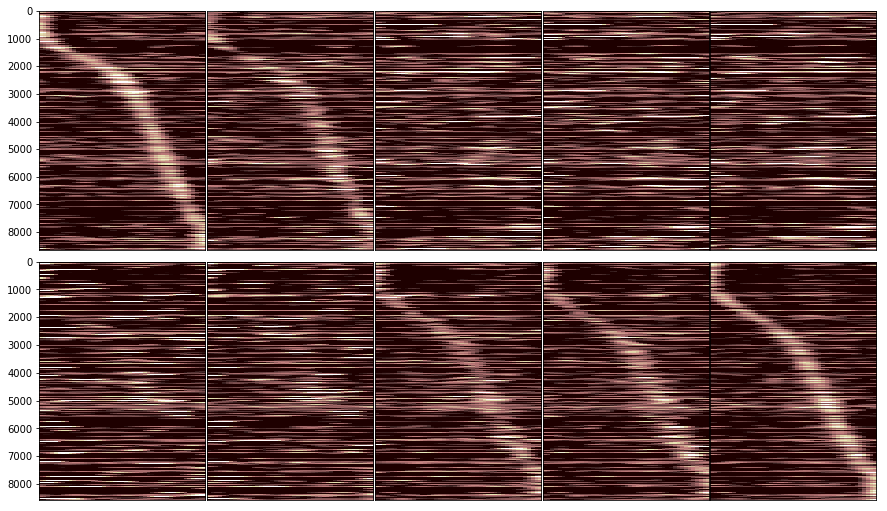

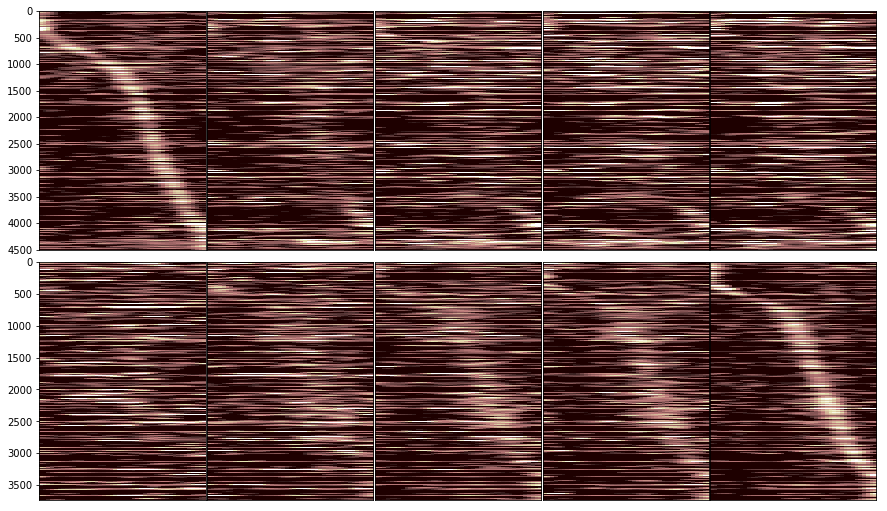

In [10]:
f_rare,ax_rare = pop_PC_plot(Rare_dict)

f_fam,ax_fam = pop_PC_plot(Fam_dict)

In [11]:
f_rare.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_manuscript\\Figures\\AllPlaceCells_Rare.pdf",format='pdf')
f_fam.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_manuscript\\Figures\\AllPlaceCells_Fam.pdf",format='pdf')


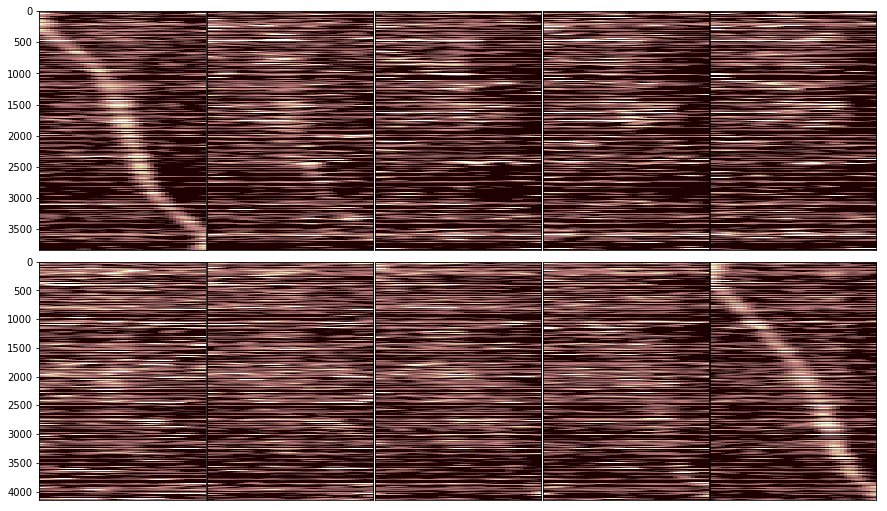

In [17]:
f_fd,ax_fd = pop_PC_plot(FD_dict)

In [18]:

f_fd.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_manuscript\\Figures\\AllPlaceCells_FD.pdf",format='pdf')

In [22]:
print(Rare_mu.shape)

(5, 45, 28409)


[[1.         0.69758288 0.45798718 0.43173625 0.44968088]
 [0.69758288 1.         0.5370719  0.50341108 0.52053233]
 [0.45798718 0.5370719  1.         0.73868308 0.75328462]
 [0.43173625 0.50341108 0.73868308 1.         0.78510743]
 [0.44968088 0.52053233 0.75328462 0.78510743 1.        ]]
[[1.         0.68693483 0.59418394 0.56628336 0.55732089]
 [0.68693483 1.         0.7280094  0.69918568 0.68686399]
 [0.59418394 0.7280094  1.         0.77460487 0.76545954]
 [0.56628336 0.69918568 0.77460487 1.         0.7823581 ]
 [0.55732089 0.68686399 0.76545954 0.7823581  1.        ]]


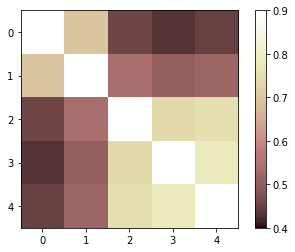

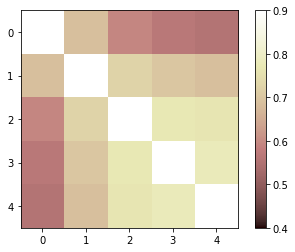

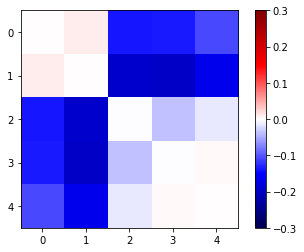

In [19]:

def mean_FR_corr(MU):
#     MU_z = sp.stats.zscore(MU,axis=-1)
#     mu_sim = np.matmul(np.transpose(MU_z,axes=[1,0,2]),np.transpose(MU_z,axes=[1,2,0])).mean(axis=0)/MU_z.shape[2]
#     print(mu_sim)
    MU_f = MU.reshape([MU.shape[0],-1])
    MU_f[np.isnan(MU_f)]=0
    MU_f /= np.linalg.norm(MU_f,2,axis=1)[:,np.newaxis]
    MU_f[np.isnan(MU_f)]=0
    mu_sim = np.matmul(MU_f,MU_f.T)
    print(mu_sim)
    f,ax = plt.subplots()
    im = ax.imshow(mu_sim,cmap='pink',vmin=.4,vmax=.9)
    f.colorbar(im)
    return mu_sim, f

rare_mu_sim,f_rare_sim = mean_FR_corr(Rare_mu)
fam_mu_sim, f_fam_sim = mean_FR_corr(Fam_mu)

f_sim_diff,ax = plt.subplots()
im = ax.imshow(rare_mu_sim-fam_mu_sim,cmap='seismic',vmin=-.3,vmax=.3)
f_sim_diff.colorbar(im)

In [21]:
f_rare_sim.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_manuscript\\Figures\\AllPlaceCells_Rare_Sim.pdf",format='pdf')
f_fam_sim.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_manuscript\\Figures\\AllPlaceCells_Fam_Sim.pdf",format='pdf')
f_sim_diff.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_manuscript\\Figures\\AllPlaceCells_Sim_Diff.pdf",format='pdf')

In [ ]:
# add permutation test for difference in similarity
# randomly permute which cells belong to which group

[[1.         0.59610093 0.52777794 0.50456796 0.50699644]
 [0.59610093 1.         0.59094561 0.54885525 0.54930982]
 [0.52777794 0.59094561 1.         0.61832865 0.61456845]
 [0.50456796 0.54885525 0.61832865 1.         0.65827096]
 [0.50699644 0.54930982 0.61456845 0.65827096 1.        ]]


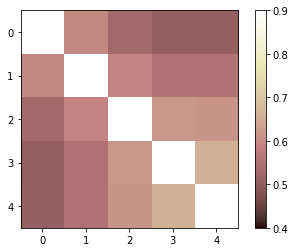

In [20]:
fd_mu_sim, f_fd_sim = mean_FR_corr(FD_mu)

In [45]:
f_fd_sim.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_manuscript\\Figures\\AllPlaceCells_FD_Sim.pdf",format='pdf')